In [1]:
# Download IMDB reviews dataset
!gdown 1v36q7Efz0mprjAv4g6TkQM2YlDKdqOuy

Downloading...
From: https://drive.google.com/uc?id=1v36q7Efz0mprjAv4g6TkQM2YlDKdqOuy
To: /content/IMDB-Dataset.csv
100% 66.2M/66.2M [00:01<00:00, 55.0MB/s]


In [2]:
# Load dataset
import pandas as pd

df = pd.read_csv('/content/IMDB-Dataset.csv')

# Remove duplicates
df = df.drop_duplicates()
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 12.2 MB/s eta 0:00:00


In [4]:
# Preprocess data
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

stop_words = set(stopwords.words('english'))

# Expanding contractions like can't, won't to their extended forms: can not, will not
def expand_contractions(text):
    return contractions.fix(text)

# Function to clean data
def preprocess_text(text):
  w1 = WordNetLemmatizer()

  soup = BeautifulSoup(text, 'html.parser') # Removing HTML tags
  text = soup.get_text()
  text = expand_contractions(text) # Expanding chatwords and contracts clearing contractions
  emoji_clean = re. compile ("["
  u"\U0001F600-\U0001F64F" # emoticons
  u"\U0001F300-\U0001F5FF" # symbols & pictographs
  u"\U0001F680-\U0001F6FF" # transport & map symbols
  u"\U0001F1E0-\U0001F1FF" # flags (iOS)
  u"\U00002702-\U000027B0"
  u"\U000024C2-\U0001F251"
  "]+", flags=re.UNICODE)
  text = emoji_clean.sub(r'', text)
  text = re.sub (r'\.(?=\S)', '. ', text ) # add space after full stop
  text = re.sub (r'http\S+', '', text) # remove urls
  text = "".join([word.lower() for word in text if word not in string.punctuation]) # remove punctuation and make text lowercase
  text = "".join([w1.lemmatize(word) for word in text.split() if word not in stop_words and word.isalpha()]) #  lemmatize
  return text

df['review'] = df['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


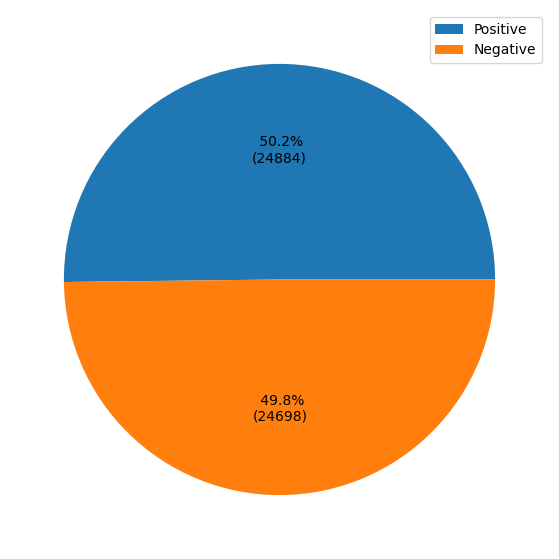

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Bar chart of number of positive and negative reviews in the dataset
# Create autopct arguments
def func(pct , allvalues) :
  absolute = int( pct / 100. * np. sum( allvalues ) )
  return " {:.1f}%\n({:d})".format (pct , absolute )

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos , freq_neg]
labels = ['Positive' , 'Negative']

# Create pie chart
fig, ax = plt.subplots(figsize = (10 , 7))
plt.pie(x=data, autopct=lambda pct : func(pct , data), )
plt.legend(labels)
plt.show()

In [6]:
# Split train and test dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
x_data = df['review']
y_data = label_encode.fit_transform(df['sentiment'])

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

In [7]:
# Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

In [8]:
# Train DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Decision Tree classifier with the entropy criterion
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

# Fit the classifier on the training data
dt_classifier.fit(x_train_encoded, y_train)

# Predict the labels for the test data
y_pred = dt_classifier.predict(x_test_encoded)

# Compute the accuracy score (using y_test as the true labels)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4980336795401835


In [9]:
# Train RandomForest
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(x_train_encoded, y_train)
y_pred = rf_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.4980336795401835

In [10]:
# Train XGBoost
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(x_train_encoded, y_train)
y_pred = xgb_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.5019663204598165

Based on evaluation, for this problem, XGBoost (50% accuracy) is the best, Decision Tree and Random Forests performed the same (49% accuracy)